#***Video Memorability Task***

---



 This collab implements the video memorability task given for assignment of CA684. The short term and long term memorability means the probability with which the viewer will remember the video. This kind of strategy is profitable in terms of Digital marketing field and other aspects of life where video is of importance. 
 
 This collab is divided into 4 section. Below is the crips description of the sections of this Collab File.
 
* Part 1 - Import Data and Define Functions
* Part 2 - Data Preporcessing
* Part 3 - Models Applied
* Part 4 - Apply models on test set
  
  







# Part 1 : Import Data and Define Functions
This part of notebook involves importing the data and defining functions used to load the features of the dataset. Below are the steps of this section
* Importing the data from the google drive, the path used here is ***content/drive/My Drive/MSc in Computing/SEM II/CA684/CA684_Assignment/***. This is path from the personal google drive.
- Imported useful libraries required for the google collab.
- Two features were loaded in the variables - Captions and C3D
- Distribution of long term and short term memorability is shown from the dev-set.
- Ground - truth csv including the values of short term and long term were loaded in the variable.


In [14]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/MSc in Computing/SEM II/CA684/CA684_Assignment/')
#4/ygGVT1bCDZk5q_pdVGG-hAA7l2zG2ORax82hFpcEBIFeUp3uEmVM71M

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [15]:
!pip install pyprind

In [0]:
import pandas as pd

from tensorflow.python.keras import Sequential
from tensorflow.python.keras import layers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.preprocessing.text import Tokenizer

import numpy as np
from string import punctuation
import pyprind
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk

In [0]:
# for reproducability
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

Load all the features used in algo & GET_SCORE 

In [0]:
#Function to calculate Spearman coefficient scores
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

Read Captions

In [0]:
# load labels and captions
def read_caps(fname):
    """Load the captions into a dataframe"""
    vn = []
    cap = []
    df = pd.DataFrame();
    with open(fname) as f:
        for line in f:
            pairs = line.split()
            vn.append(pairs[0])
            cap.append(pairs[1])
        df['video']=vn
        df['caption']=cap
    return df

#load c3d Features
def load_c3d(captions, c3dPath):
    files = list(captions["video"].values)
    c3dfeatures = []
    for file in files:
        file = c3dPath+file[:-4]+'txt'
        c3dfeatures.append(np.loadtxt(file))
    #print(type(c3dfeatures))
    return c3dfeatures



In [0]:

# load the captions
cap_path = './Dev-set/Captions/dev-set_video-captions.txt'
captions=read_caps(cap_path)


In [21]:
captions.shape

(6000, 2)

In [22]:
from tqdm import tqdm as tqdm
from pathlib import Path
import pandas as pd

def read_C3D(fname):
    """Scan vectors from file"""
    with open(fname) as f:
        for line in f:
            C3D =[float(item) for item in line.split()] # convert to float type, using default separator
    return C3D

c3d_path = Path('./Dev-set/C3D/')
list(c3d_path.glob('*.txt'))

c3d_feat_dict ={}

for file in tqdm (list(c3d_path.glob('*.txt'))):                                                                                                                 
  key = file.with_suffix('.webm').name
  c3d_feat_dict[key] = read_C3D(file)


c3d_feat= pd.DataFrame(c3d_feat_dict).T.reset_index()
c3d_feat= c3d_feat.rename(columns={'index':'video'})

100%|██████████| 6000/6000 [00:06<00:00, 861.97it/s]


In [0]:

#load C3D features
c3dPath = './Dev-set/C3D/'
c3dfeatures = load_c3d(captions,c3dPath)


In [0]:

# load the ground truth values
label_path = './Dev-set/Ground-truth/'
labels=pd.read_csv(label_path+'ground-truth.csv')

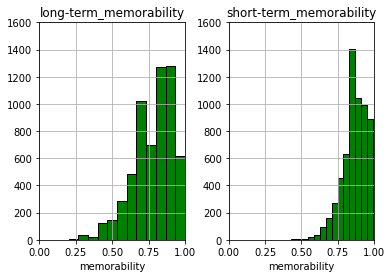

In [25]:
# histogram of labels
bins = 15
figs = labels[['short-term_memorability', 'long-term_memorability']].hist(bins=bins,color = 'green',edgecolor = 'black')

for fig in figs[0]:
  fig.set_xlabel('memorability')
  fig.set_ylim(0, 1600)
  fig.set_xlim(0, 1)
  fig.set_xlabel('memorability')
  fig.set_ylim(0, 1600)
  fig.set_xlim(0, 1)

# Part 2 : Pre-Processing of Data
 - This section involves pre processing of features like captions and c3d features.
 - This section uses ntlk - stopwords to remove the captions from the dev and test dataset. - turning the captions into integer using the tokenizer functions.

In [26]:
print(c3dfeatures)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [27]:
print(captions.head())

          video                                            caption
0   video3.webm                 blonde-woman-is-massaged-tilt-down
1   video4.webm  roulette-table-spinning-with-ball-in-closeup-shot
2   video6.webm                                      khr-gangsters
3   video8.webm               medical-helicopter-hovers-at-airport
4  video10.webm               couple-relaxing-on-picnic-crane-shot


In [28]:
print(f'Ground Truth : {labels.shape}')
print(f'Dev Captions : {captions.shape}')
print(f'C3D          : ({len(c3dfeatures)})')
#print(f'HMP          : ({len(hmp_features)})')

Ground Truth : (6000, 5)
Dev Captions : (6000, 2)
C3D          : (6000)


In [29]:
#loading the nltk stopwords of English
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
print(f'Length of Stopwords: {len(stopwords)}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Length of Stopwords: 179


In [30]:
counts = Counter()
# setup prograss tracker
pbar = pyprind.ProgBar(len(captions['caption']), title='Counting word occurrences')
for i, cap in enumerate(captions['caption']):
    # replace punctuations with space
    # convert words to lower case 
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    captions.loc[i,'caption'] = text
    pbar.update()
    counts.update(text.split())

Counting word occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


In [31]:
print(counts)
print(len(counts))

Counter({'in': 2105, 'the': 1835, 'on': 1724, 'and': 1444, 'a': 1181, 'with': 996, 'woman': 899, 'of': 836, 'at': 762, 'young': 724, 'man': 559, 'slow': 495, 'motion': 452, 'to': 416, 'couple': 318, 'sitting': 304, 'girl': 291, 'happy': 279, 'beach': 270, 'park': 256, 'up': 255, 'walking': 237, 'close': 230, 'camera': 230, 'her': 219, 'using': 218, 'shot': 215, 'smiling': 198, 'looking': 195, 'two': 191, 'by': 189, 'people': 188, 'from': 188, 'tablet': 184, 'is': 181, 'water': 171, 'through': 156, 'female': 150, 'computer': 149, 'view': 149, 'laptop': 139, 'playing': 137, 'sunset': 137, 'beautiful': 133, 'videoblocks': 131, 'his': 131, 'running': 130, 'talking': 129, 'city': 128, 'working': 127, 'eating': 126, 'little': 126, 'family': 125, 'mother': 124, 'background': 122, 'home': 122, 'standing': 121, 'for': 115, 'phone': 115, 'or': 114, 'sea': 113, 'national': 112, 'african': 111, 'attractive': 111, 'tree': 107, 'snow': 103, 'their': 102, 'drinking': 102, 'hands': 102, 'steadicamof':

In [32]:
captions.head()

,video,caption
0,video3.webm,blonde woman is massaged tilt down
1,video4.webm,roulette table spinning with ball in closeup shot
2,video6.webm,khr gangsters
3,video8.webm,medical helicopter hovers at airport
4,video10.webm,couple relaxing on picnic crane shot


In [33]:
captions.shape

(6000, 2)

In [34]:
# build the word index
len_token = len(counts)
tokenizer = Tokenizer(num_words=len_token)
print(len_token)

5191


In [0]:
tokenizer.fit_on_texts(list(captions.caption.values)) #fit a list of captions to the tokenizer
#the tokenizer vectorizes a text corpus, by turning each text into either a sequence of integers 

In [36]:
print(len(tokenizer.word_index))

5191


In [0]:
one_hot_res = tokenizer.texts_to_matrix(list(captions.caption.values),mode='binary')
sequences = tokenizer.texts_to_sequences(list(captions.caption.values))

In [38]:
#Just to visualise some stuff in sequences and counts
print(sequences[0]) # prints location of words from caption 0 'blonde woman is massaged tilt down'
print(counts['blonde']) # no. of occurences of 'blonde'
n=3
print('Least Common: ', counts.most_common()[:-n-1:-1])       # n least common elements
print('Most Common: ',counts.most_common(n))                     # n most common elements

[724, 7, 35, 884, 384, 91]
10
Least Common:  [('unknown', 1), ('handheldshowing', 1), ('longof', 1)]
Most Common:  [('in', 2105), ('the', 1835), ('on', 1724)]


In [39]:
#implementing bag of words for the combined captions
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",max_features=3112) 
captions_bag = vectorizer.fit_transform(captions.caption).toarray()
type(captions_bag)

numpy.ndarray

In [40]:
one_hot_res

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [41]:
captions_bag.shape

(6000, 3112)

In [0]:
captions_c3d = (captions_bag.tolist())
counter = 0
for item in range(6000):
    captions_c3d[counter] = np.append(captions_c3d[counter],c3dfeatures[counter],axis=0)
    counter = counter+1

In [43]:
len(captions_c3d[0])

3213

In [44]:
len(captions_c3d)

6000

In [0]:
# calculating max length
max_len = 50

In [46]:
print(sequences[0]) # length of 1st sequence

[724, 7, 35, 884, 384, 91]


In [47]:
X_seq = np.zeros((len(sequences),max_len))
for i in range(len(sequences)):
    n = len(sequences[i])
    if n==0:
        print(i)
    else:
        X_seq[i,-n:] = sequences[i]
X_seq.shape

(6000, 50)

# Part 3

Model application with features, both C3D and captions. Here we have applied total of 5 models, which comprise of SVR , Random Forest and RNN. The combination of features are used to apply several models as well. Below is the list of model applied on the features of caption and C3D

1. Random Forest With C3D
2. SVR with C3D 
3. Random Forest with Captions and C3D
4. RF with Captions
5. SVR with Captions
6. RNN - Recurrent Neural Network

After preprocessing the captions to be ready for the models, we have split the data in training and testing set. The size of training set is 4800 and test set is of around 1200.

With the above models we have calculated the Spearman coefficient on the test dataset. The chart for the same can be seen at the end of this section. Using that data we can clearly see what models has performed well on the dataset and which is not a good model to choose for the prediction of test-set.


**RANDOM FOREST WITH C3D**

---





In [0]:
X = c3dfeatures
y = labels[['short-term_memorability','long-term_memorability']].values

In [0]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [0]:


from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=20,random_state=42,verbose=2)



In [0]:


rf_regressor.fit(X_train,y_train)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.3s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=None, oob_score=False,
                      random_state=42, verbose=2, warm_start=False)

In [0]:
rf_pred = rf_regressor.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


In [0]:
Get_score(rf_pred, y_test)

The Spearman's correlation coefficient is: 0.266
The Spearman's correlation coefficient is: 0.122


## **SVR with C3D**



---



In [0]:
svr_X = c3dfeatures
svr_y_short = labels[['short-term_memorability']].values
svr_y_long = labels[['long-term_memorability']].values

In [0]:
# Splitting the dataset into the Training set and Test set
short_X_train,short_X_test,short_y_train,short_y_test = train_test_split(svr_X,svr_y_short,test_size=0.2,random_state=40)
long_X_train,long_X_test,long_y_train,long_y_test = train_test_split(svr_X,svr_y_long,test_size=0.2,random_state=40)

In [0]:
from sklearn.preprocessing import StandardScaler
short_X = StandardScaler()
short_y = StandardScaler()
short_X_train = short_X.fit_transform(short_X_train)
short_y_train = short_y.fit_transform(short_y_train)
long_X = StandardScaler()
long_y = StandardScaler()
long_X_train = long_X.fit_transform(long_X_train)
long_y_train = long_y.fit_transform(long_y_train)

In [0]:
from sklearn.svm import SVR
short_regressor = SVR(kernel = 'rbf')
long_regressor = SVR(kernel = 'rbf')
short_regressor.fit(short_X_train, short_y_train)
long_regressor.fit(long_X_train,long_y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
short_pred = short_regressor.predict(short_X_test)
short_pred = short_y.inverse_transform(short_pred)
long_pred = long_regressor.predict(long_X_test)
long_pred = long_y.inverse_transform(long_pred)

In [0]:
Get_score(short_pred, short_y_test)
Get_score(long_pred, long_y_test)

The Spearman's correlation coefficient is: 0.242
The Spearman's correlation coefficient is: 0.107


## **Random Forest with Captions and C3D**
---







In [0]:
X = captions_c3d
y = labels[['short-term_memorability','long-term_memorability']].values

In [0]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [0]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=50,random_state=45,verbose=2)

In [78]:
rf_regressor.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   51.6s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=45, verbose=2, warm_start=False)

In [79]:
rf_pred = rf_regressor.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


In [80]:
Get_score(rf_pred, y_test)

The Spearman's correlation coefficient is: 0.332
The Spearman's correlation coefficient is: 0.111


## **SVR with C3D AND CAPTIONS**

---



In [0]:
svr_X = captions_c3d
svr_y_short = labels[['short-term_memorability']].values
svr_y_long = labels[['long-term_memorability']].values

In [0]:
# Splitting the dataset into the Training set and Test set
short_X_train,short_X_test,short_y_train,short_y_test = train_test_split(svr_X,svr_y_short,test_size=0.2,random_state=40)
long_X_train,long_X_test,long_y_train,long_y_test = train_test_split(svr_X,svr_y_long,test_size=0.2,random_state=40)

In [0]:
from sklearn.preprocessing import StandardScaler
short_X = StandardScaler()
short_y = StandardScaler()
short_X_train = short_X.fit_transform(short_X_train)
short_y_train = short_y.fit_transform(short_y_train)
long_X = StandardScaler()
long_y = StandardScaler()
long_X_train = long_X.fit_transform(long_X_train)
long_y_train = long_y.fit_transform(long_y_train)

In [0]:
from sklearn.svm import SVR
short_regressor = SVR(kernel = 'rbf')
long_regressor = SVR(kernel = 'rbf')
short_regressor.fit(short_X_train, short_y_train)
long_regressor.fit(long_X_train,long_y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
short_pred = short_regressor.predict(short_X_test)
short_pred = short_y.inverse_transform(short_pred)
long_pred = long_regressor.predict(long_X_test)
long_pred = long_y.inverse_transform(long_pred)

In [0]:
Get_score(short_pred, short_y_test)
Get_score(long_pred, long_y_test)

The Spearman's correlation coefficient is: 0.348
The Spearman's correlation coefficient is: 0.191


## **RF with Captions** 

---



In [0]:
  X = captions_bag
  y = labels[['short-term_memorability','long-term_memorability']].values

In [0]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [0]:
print('X_train ', X_train.shape)
print('X_test  ', X_test.shape)
print('Y_train ', y_train.shape)
print('Y_test  ', y_test.shape)

X_train  (4800, 3112)
X_test   (1200, 3112)
Y_train  (4800, 2)
Y_test   (1200, 2)


In [0]:
from sklearn.ensemble import RandomForestRegressor
captions_rf = RandomForestRegressor(n_estimators=100,random_state=45)

In [0]:
captions_rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=45, verbose=0, warm_start=False)

In [0]:
captions_pred = captions_rf.predict(X_test)

In [0]:
Get_score(captions_pred, y_test)

The Spearman's correlation coefficient is: 0.417
The Spearman's correlation coefficient is: 0.167




## SVR with Captions ********
 


In [0]:
svr_X = captions_bag
svr_y_short = labels[['short-term_memorability']].values
svr_y_long = labels[['long-term_memorability']].values

In [0]:
# Splitting the dataset into the Training set and Test set
short_X_train,short_X_test,short_y_train,short_y_test = train_test_split(svr_X,svr_y_short,test_size=0.2,random_state=40)
long_X_train,long_X_test,long_y_train,long_y_test = train_test_split(svr_X,svr_y_long,test_size=0.2,random_state=40)

In [0]:
from sklearn.preprocessing import StandardScaler
short_X = StandardScaler()
short_y = StandardScaler()
short_X_train = short_X.fit_transform(short_X_train)
short_y_train = short_y.fit_transform(short_y_train)
long_X = StandardScaler()
long_y = StandardScaler()
long_X_train = long_X.fit_transform(long_X_train)
long_y_train = long_y.fit_transform(long_y_train)

In [0]:
from sklearn.svm import SVR
short_regressor = SVR(kernel = 'rbf')
long_regressor = SVR(kernel = 'rbf')
short_regressor.fit(short_X_train, short_y_train)
long_regressor.fit(long_X_train,long_y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
short_pred = short_regressor.predict(short_X_test)
long_pred = long_regressor.predict(long_X_test)
long_pred = long_y.inverse_transform(long_pred)

In [0]:
Get_score(short_pred, short_y_test)
Get_score(long_pred, long_y_test)

The Spearman's correlation coefficient is: 0.324
The Spearman's correlation coefficient is: 0.191


## RNN - Recurrent Neural Network with Captions

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(input_dim=5191, output_dim=20, input_length=50, embeddings_initializer="uniform")`
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4800 samples, validate on 1200 samples
Epoch 1/10
4800/4800 [==============================] - 22s 5ms/step - loss: 0.0496 - accuracy: 0.6658 - val_loss: 0.0309 - val_accuracy: 0.7100
Epoch 2/10
4800/4800 [==============================] - 20s 4ms/step - loss: 0.0294 - accuracy: 0.6794 - val_loss: 0.0214 - val_accuracy: 0.7100
Epoch 3/10
4800/4800 [==============================] - 19s 4ms/step - loss: 0.0232 - accuracy: 0.6835 - val_loss: 0.0181 - val_accuracy: 0.7100
Epoch 4/10
4800/4800 [==============================] - 19s 4ms/step - loss: 0.0200 - accuracy: 0.6852 - val_loss: 0.0164 - val_accuracy: 0.7100
Epoch 5/10
4800/4800 [==============================] - 19s 4ms/step - loss: 0.0184 - accuracy: 0.6950 - val_loss: 0.0154 - val_accuracy: 0.7100
Epoch 6/10
4800/4800 [==============================] - 20s 4ms/step - loss: 0.0172 - accuracy: 0.6979 - val_loss: 0.0145 - val_accuracy: 0.7100
Epoch 7/10
4800/4800 [==============================] - 19s 4ms/step - loss: 0.016

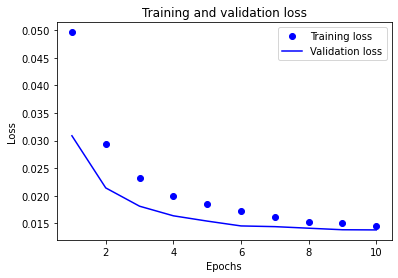

In [90]:
from keras import Sequential
from keras import layers
from keras import regularizers

# Some prequisites for RNN
## sequences will be our X variable
## predictor will be our Y variable
predictor = labels[['short-term_memorability','long-term_memorability']].values
Y = predictor
X = X_seq
## Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)


## Recurrent Neural Network Model 
## All hyperparameters are selected using GridSearch and Trial & Error Approach

model=Sequential() # Create Sequential NN model

## add Embedding layer for RNN to map our data into a format suitable for LSTM layer
model.add(layers.Embedding(input_dim=5191, output_dim=20, input_length=50, init='uniform'))

## add LSTM layer for some hidden layer and memory into the network
model.add(layers.LSTM(150, activation='selu', recurrent_initializer='uniform', kernel_initializer='zeros', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.2))

## layer of 30 neurons to map down from 150 hidden neurons with ridge regularizer
model.add(layers.Dense(30, activation='selu', kernel_regularizer=regularizers.l2(0.001)))

## Dropout layer
model.add(layers.Dropout(0.6))

## Output layer of 2 neurons for each score with sigmoid activation 
model.add(layers.Dense(2, activation='sigmoid'))

## Compile the model 
# Optimizer Adamax
model.compile(optimizer='adamax',loss='mse',metrics=['accuracy'])


## Training the model 
# Number of epochs also comes from Gridsearch
history = model.fit(X_train,Y_train,epochs=10, validation_data=(X_test,Y_test))

# visualizing the model
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [93]:
predictions = model.predict(X_test)
predictions.shape

(1200, 2)

In [94]:
import scipy
rho = scipy.stats.spearmanr(predictions, Y_test)[0]
print(rho)
print("Short-term:", rho[2][1])
print("Long-term:", rho[3][1])

[[1.         0.99986638 0.41722258 0.20358836]
 [0.99986638 1.         0.4170695  0.20326541]
 [0.41722258 0.4170695  1.         0.34074423]
 [0.20358836 0.20326541 0.34074423 1.        ]]
Short-term: 0.4170695045213794
Long-term: 0.203265412855991


# Part 4 - Applying Model on test set

Comparing the above models we have applied we can see in the graph clearly that the Random forest model with captions has the highest spearman coefficient. In this section we have imported the test data from the google drive in the same we way we have imported the data of training(dev-set). The captions feature of the test data is loaded and processed as per above models.

Implementing the Random Forest on the dataset gave us below results. Please go through all the cells in detals to check the predicted score. At the end I have presented all the preidcted values of short-term and long-term memorability in the file.

In [0]:
#importing test Dataset
csv_path ='./Test-set/Ground-truth_test/'
test_dataset = pd.read_csv(csv_path+'ground_truth_template.csv')


In [101]:
c3dPath_test


'./Test-set/C3D_test/'

In [0]:
#load the test set captions
test_captions_path ='./Test-set/Captions_test/test-set-1_video-captions.txt'
test_captions = read_caps(test_captions_path)

In [103]:
test_dataset.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,NaN,33,NaN,12
1,7495,NaN,34,NaN,10
2,7496,NaN,32,NaN,13
3,7497,NaN,33,NaN,10
4,7498,NaN,33,NaN,10


In [104]:
test_captions.head()

,video,caption
0,video7494.webm,green-jeep-struggling-to-drive-over-huge-rocks
1,video7495.webm,hiking-woman-tourist-is-walking-forward-in-mou...
2,video7496.webm,close-up-of-african-american-doctors-hands-usi...
3,video7497.webm,slow-motion-of-a-man-using-treadmill-in-the-gy...
4,video7498.webm,slow-motion-of-photographer-in-national-park


In [105]:
#printing the dimensions of test-set dataset and features
print(f'Test-Dataset : {test_dataset.shape}')
print(f'Test-Captions: {test_captions.shape}')

Test-Dataset : (2000, 5)
Test-Captions: (2000, 2)


In [106]:
#Removing punctuations and stop words from captions
# setup prograss tracker
pbar = pyprind.ProgBar(len(test_captions['caption']), title='Counting word occurrences')
for i, cap in enumerate(test_captions['caption']):
    # replace punctuations with space
    # convert words to lower case 
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    #removing stopwords
    rmv_stopwords= ' '.join([word for word in text.split() if word not in stopwords])
    test_captions.loc[i,'caption'] = rmv_stopwords #updating the original captions 
    pbar.update()

Counting word occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [107]:
test_captions.head()

,video,caption
0,video7494.webm,green jeep struggling drive huge rocks
1,video7495.webm,hiking woman tourist walking forward mountains...
2,video7496.webm,close african american doctors hands using sph...
3,video7497.webm,slow motion man using treadmill gym regular ph...
4,video7498.webm,slow motion photographer national park


In [108]:
#implementing bag of words for the combined captions
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",max_features=3122) 
test_captions_bag = vectorizer.fit_transform(test_captions.caption).toarray()
type(test_captions_bag)

numpy.ndarray

In [109]:


print(f'Testing Bag of words size     : {len(test_captions_bag)}')
print(f'Development Bag of words size : {len(captions_bag)}')
print(f'Development Vocabulary Size   : {len(captions_bag[0])}')
print(f'Testing Vocabulary Size       : {len(test_captions_bag[0])}')



Testing Bag of words size     : 2000
Development Bag of words size : 6000
Development Vocabulary Size   : 3112
Testing Vocabulary Size       : 3112


In [0]:
test_pred = captions_rf.predict(test_captions_bag)

In [0]:
pred = pd.DataFrame()

In [113]:
type(test_pred)

numpy.ndarray

In [0]:
pred['short-term'] = test_pred[:,0]

In [0]:
pred['long-term'] = test_pred[:,1]

In [116]:
pred.head()

,short-term,long-term
0,0.858188,0.769879
1,0.810469,0.733451
2,0.753894,0.719755
3,0.780523,0.596919
4,0.854220,0.782344


In [117]:
pred.describe()

,short-term,long-term
count,2000.000000,2000.000000
mean,0.846119,0.751515
std,0.031538,0.060369
min,0.686637,0.447874
25%,0.834821,0.722281
50%,0.850717,0.761942
75%,0.864708,0.788985
max,0.932072,0.920705


In [118]:
import pandas as pd
from IPython.core.display import HTML

#df=pd.read_pickle('Data1')
display(HTML(pred.to_html()))

,short-term,long-term
0,0.858188,0.769879
1,0.810469,0.733451
2,0.753894,0.719755
3,0.780523,0.596919
4,0.854220,0.782344
5,0.825936,0.618528
6,0.846098,0.804072
7,0.835313,0.751996
8,0.720081,0.746567
9,0.799790,0.578585



>                                      **END**



